# Comprehensive Raw Data Preprocessing Pipeline Tutorial

This notebook demonstrates a detailed and comprehensive raw data preprocessing pipeline for biosignals. The pipeline covers:

- Simulation of multiple biosignals (e.g., EDA, EMG, Respiration, ECG)
- Signal validation and artifact detection/removal
- Basic filtering using Butterworth filters (low-pass, bandpass, notch)
- Advanced denoising (using wavelet thresholding for ECG)
- Normalization and segmentation
- Wrapping all steps in a modular preprocessing class

Finally, we show an example of how to integrate the preprocessing pipeline into machine learning and deep learning workflows.

## Table of Contents

1. Environment Setup & Imports
2. Simulation of Raw Biosignals
3. Visualization of Raw Signals
4. Detailed Preprocessing Steps:
   - Signal Validation & Artifact Detection
   - Filtering (Low-pass, Bandpass, Notch)
   - Advanced Denoising
   - Normalization & Segmentation
5. ComprehensivePreprocessor Class
6. Integration into ML/DL Pipelines
7. Conclusion

In [1]:
import sys
import os

# Get the repository root folder (assuming the notebook is in /your-project-root/notebooks)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Project root added to sys.path:", project_root)

# Environment Setup & Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
import neurokit2 as nk
import torch

# For advanced denoising, we assume the repository provides a wavelet_denoise function
from ecg_processor_torch.advanced_denoising import wavelet_denoise
from ecg_processor_torch.config import ECGConfig

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Environment setup complete. ECG sampling rate:", ECGConfig.DEFAULT_SAMPLING_RATE)

Project root added to sys.path: /Users/linh/Downloads/ECGPreprocessor
Environment setup complete. ECG sampling rate: 500


In [2]:
# 1. Simulate Raw Biosignals
fs = 500  # Sampling frequency in Hz
duration = 10  # seconds
t = np.linspace(0, duration, fs * duration)

# Simulate EDA: slow sinusoid with added noise
eda = 0.5 * np.sin(0.2 * 2 * np.pi * t) + 0.05 * np.random.randn(len(t))

# Simulate EMG: high-frequency sine wave with noise
emg = 0.1 * np.sin(20 * 2 * np.pi * t) + 0.02 * np.random.randn(len(t))

# Simulate Respiration: low-frequency oscillation + noise
resp = 0.3 * np.sin(0.5 * 2 * np.pi * t) + 0.03 * np.random.randn(len(t))

# Simulate ECG using NeuroKit2 (with noise)
ecg = nk.ecg_simulate(duration=10, sampling_rate=fs, noise=0.1)

print("Simulated signals with length:", len(t))

Simulated signals with length: 5000


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


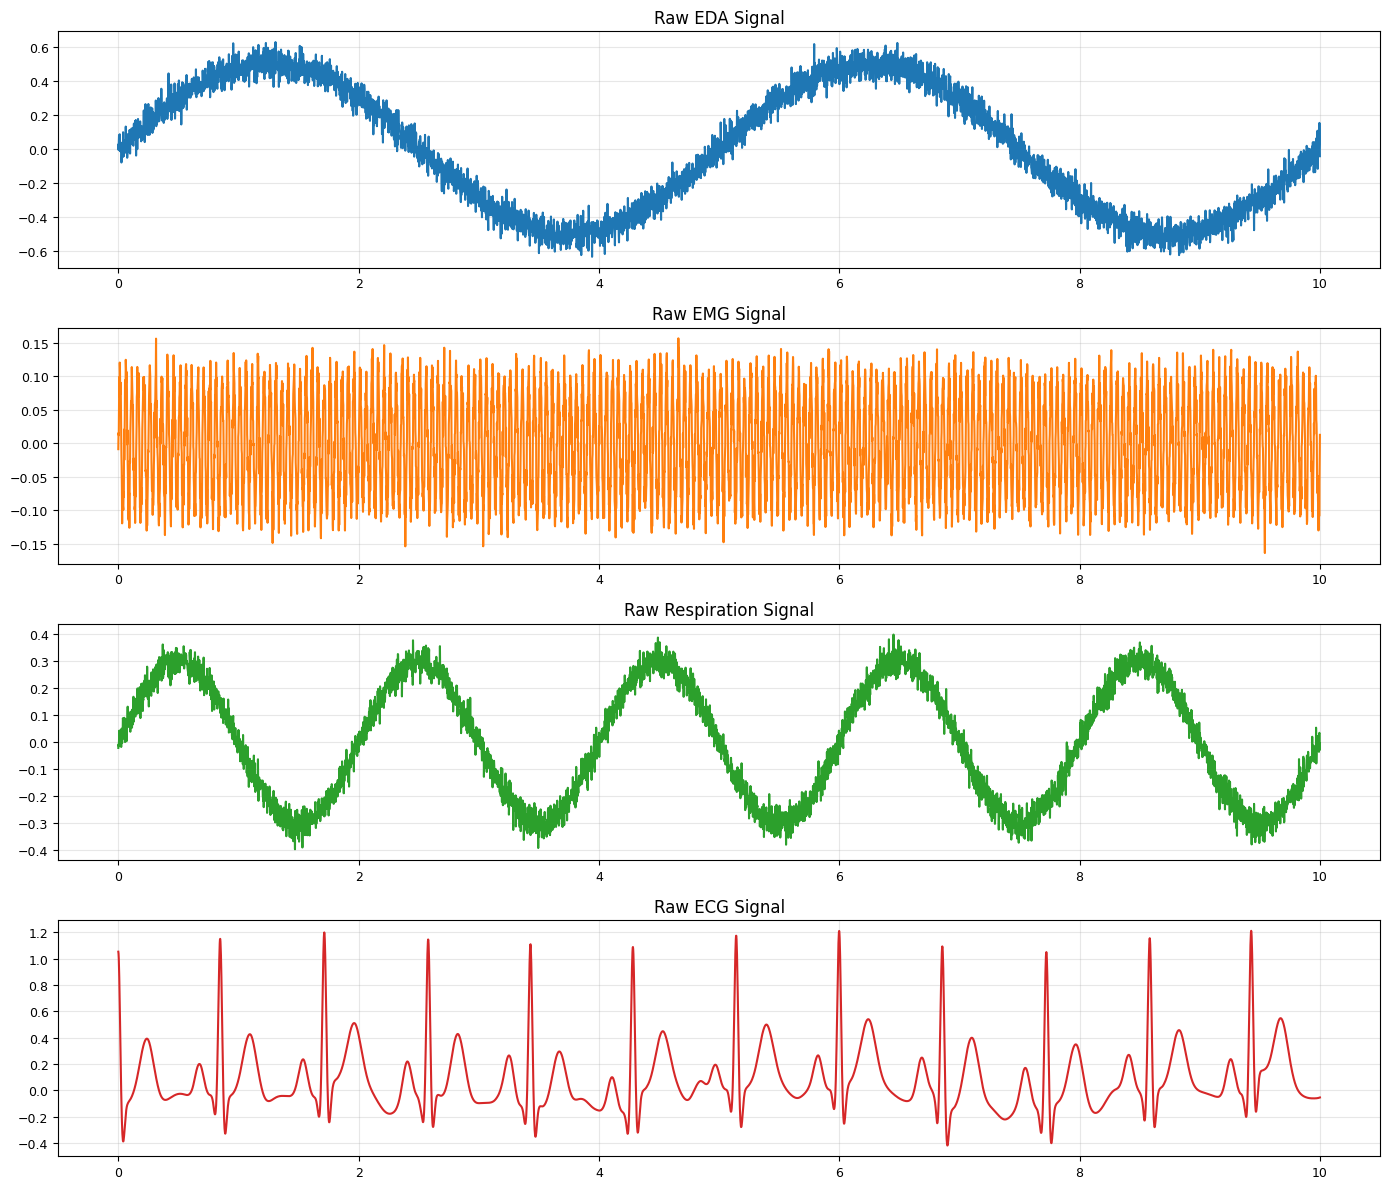

In [3]:
# 2. Visualization of Raw Signals
plt.figure(figsize=(14, 12))

plt.subplot(4, 1, 1)
plt.plot(t, eda, color='tab:blue')
plt.title('Raw EDA Signal')

plt.subplot(4, 1, 2)
plt.plot(t, emg, color='tab:orange')
plt.title('Raw EMG Signal')

plt.subplot(4, 1, 3)
plt.plot(t, resp, color='tab:green')
plt.title('Raw Respiration Signal')

plt.subplot(4, 1, 4)
plt.plot(t, ecg, color='tab:red')
plt.title('Raw ECG Signal')

plt.tight_layout()
plt.show()

## Detailed Preprocessing Steps

### Step 1: Signal Validation & Artifact Detection

Before any processing, we validate signals (ensure the signal is of the correct type, contiguous, and has no negative strides) and detect artifacts. Here, we use a simple median absolute deviation (MAD) method to flag outliers.

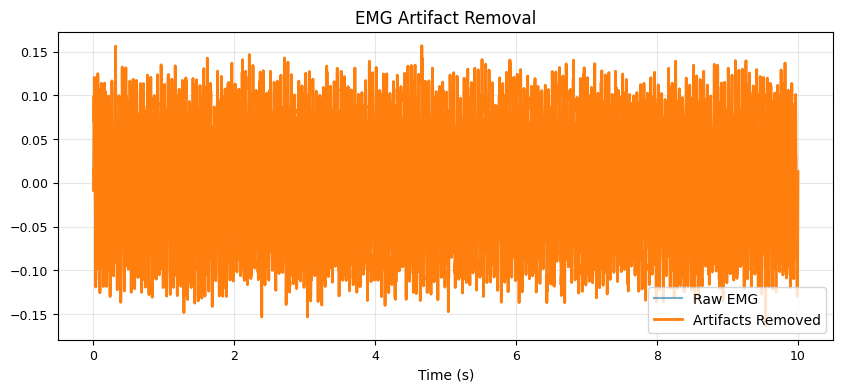

In [4]:
def validate_signal(signal):
    """Ensure the signal is a contiguous NumPy array."""
    if not isinstance(signal, np.ndarray):
        signal = np.array(signal)
    # Ensure the array is contiguous
    signal = np.ascontiguousarray(signal)
    return signal

def detect_artifacts(signal, threshold=3.0):
    """Use MAD to detect artifacts (outliers) in the signal."""
    signal = validate_signal(signal)
    median = np.median(signal)
    mad = np.median(np.abs(signal - median))
    # Compute a robust z-score
    robust_z = np.abs((signal - median) / (mad + 1e-6))
    artifacts = robust_z > threshold
    return artifacts

def remove_artifacts(signal, threshold=3.0):
    """Replace outliers with the median value (simple approach)."""
    artifacts = detect_artifacts(signal, threshold)
    clean_signal = signal.copy()
    median = np.median(signal)
    clean_signal[artifacts] = median
    return clean_signal

# Example: Validate and remove artifacts from the EMG signal
emg_validated = validate_signal(emg)
emg_artifacts_removed = remove_artifacts(emg_validated, threshold=3.0)

plt.figure(figsize=(10, 4))
plt.plot(t, emg, label='Raw EMG', alpha=0.6)
plt.plot(t, emg_artifacts_removed, label='Artifacts Removed', linewidth=2)
plt.title('EMG Artifact Removal')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

### Step 2: Filtering Functions

We implement filtering functions including low-pass, bandpass, and notch filters. These filters help remove unwanted frequency components (e.g., high-frequency noise, power line interference).

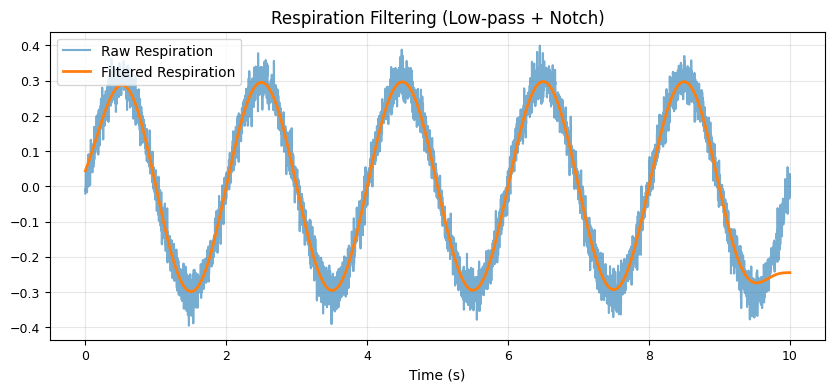

In [5]:
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def filter_signal(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    return filtfilt(b, a, data)

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data)

def notch_filter(data, fs, freq=50.0, Q=30.0):
    """Remove power line interference (default 50 Hz) using a notch filter."""
    nyquist = 0.5 * fs
    freq_norm = freq / nyquist
    b, a = iirnotch(freq_norm, Q)
    return filtfilt(b, a, data)

# Example: Apply low-pass and notch filtering to the Respiration signal
resp_filtered = filter_signal(resp, cutoff=1.0, fs=fs, order=3)
resp_notched = notch_filter(resp_filtered, fs, freq=50.0, Q=30.0)

plt.figure(figsize=(10, 4))
plt.plot(t, resp, label='Raw Respiration', alpha=0.6)
plt.plot(t, resp_notched, label='Filtered Respiration', linewidth=2)
plt.title('Respiration Filtering (Low-pass + Notch)')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

### Step 3: Advanced Denoising

For signals such as ECG, advanced denoising (like wavelet thresholding) can better separate noise from useful signal components. In our pipeline, we use the `wavelet_denoise` function imported from our repository.

Note: This function is designed to leverage PyTorch for GPU acceleration.

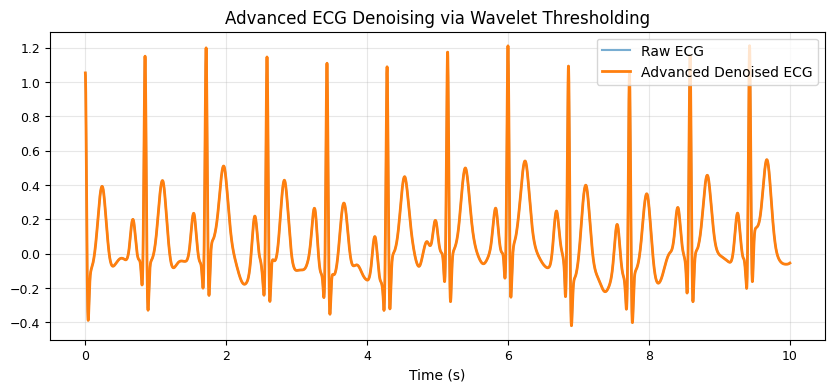

In [9]:
# Advanced Denoising for ECG
def advanced_ecg_denoising(ecg_signal):
    # Ensure the input array is contiguous with positive strides
    ecg_signal_contig = np.ascontiguousarray(ecg_signal)
    ecg_tensor = torch.tensor(ecg_signal_contig, dtype=torch.float32)
    denoised_tensor = wavelet_denoise(ecg_tensor)
    return denoised_tensor.cpu().numpy()

# Example: Apply advanced denoising to the simulated ECG
ecg_advanced = advanced_ecg_denoising(ecg)

plt.figure(figsize=(10, 4))
plt.plot(t, ecg, label='Raw ECG', alpha=0.6)
plt.plot(t, ecg_advanced, label='Advanced Denoised ECG', linewidth=2)
plt.title('Advanced ECG Denoising via Wavelet Thresholding')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

### Step 4: Normalization & Segmentation

Normalizing signals (e.g., to zero mean and unit variance) helps improve model training. In addition, many applications require splitting signals into fixed-length segments for analysis or to serve as samples for training.

Below, we define simple functions for normalization and segmentation.

In [10]:
def normalize_signal(signal):
    """Standardize signal to zero mean and unit variance."""
    signal = validate_signal(signal)
    mean = np.mean(signal)
    std = np.std(signal) + 1e-6
    return (signal - mean) / std

def segment_signal(signal, segment_length, overlap=0.0):
    """Segment the signal into chunks of fixed length. Overlap (0.0 to 1.0) determines the fraction of overlap between segments."""
    signal = validate_signal(signal)
    step = int(segment_length * (1 - overlap))
    segments = []
    for start in range(0, len(signal) - segment_length + 1, step):
        segments.append(signal[start:start + segment_length])
    return np.array(segments)

# Example: Normalize and segment the ECG (advanced denoised version)
ecg_norm = normalize_signal(ecg_advanced)
segments = segment_signal(ecg_norm, segment_length=fs*2, overlap=0.5)  # 2-second segments, 50% overlap

print("Segments shape:", segments.shape)

Segments shape: (9, 1000)


## Step 5: ComprehensivePreprocessor Class

We now wrap all of the above steps into a single modular class. This class will:

- Validate signals
- Remove artifacts
- Apply filtering (low-pass, bandpass, notch)
- Perform advanced denoising (for ECG)
- Normalize and segment the signals

This design lets you easily extend or modify any part of the pipeline.

In [11]:
class ComprehensivePreprocessor:
    def __init__(self, fs=500):
        self.fs = fs
        
    def validate(self, signal):
        return validate_signal(signal)
    
    def remove_artifacts(self, signal, threshold=3.0):
        return remove_artifacts(signal, threshold)
    
    def apply_lowpass(self, signal, cutoff, order=3):
        return filter_signal(signal, cutoff, self.fs, order=order)
    
    def apply_bandpass(self, signal, lowcut, highcut, order=4):
        return bandpass_filter(signal, lowcut, highcut, self.fs, order=order)
    
    def apply_notch(self, signal, freq=50.0, Q=30.0):
        return notch_filter(signal, self.fs, freq=freq, Q=Q)
    
    def advanced_denoise(self, signal):
        return advanced_ecg_denoising(signal)
    
    def normalize(self, signal):
        return normalize_signal(signal)
    
    def segment(self, signal, segment_length, overlap=0.0):
        return segment_signal(signal, segment_length, overlap)
    
    def preprocess_ecg(self, ecg_signal):
        # A complete example for an ECG signal
        sig = self.validate(ecg_signal)
        sig = self.remove_artifacts(sig)
        sig = self.apply_lowpass(sig, cutoff=40)  # remove high-frequency noise
        sig = self.advanced_denoise(sig)  # advanced denoising
        sig = self.normalize(sig)
        return sig
    
    def preprocess_signal(self, signal, filter_type='lowpass', **kwargs):
        # Generic preprocessing for other signals
        sig = self.validate(signal)
        sig = self.remove_artifacts(sig)
        if filter_type == 'lowpass':
            cutoff = kwargs.get('cutoff', 1.0)
            sig = self.apply_lowpass(sig, cutoff=cutoff)
        elif filter_type == 'bandpass':
            lowcut = kwargs.get('lowcut', 20)
            highcut = kwargs.get('highcut', 150)
            sig = self.apply_bandpass(sig, lowcut=lowcut, highcut=highcut)
        sig = self.normalize(sig)
        return sig

# Instantiate preprocessor
preprocessor = ComprehensivePreprocessor(fs=fs)

# Process the simulated ECG signal using the comprehensive pipeline
ecg_processed = preprocessor.preprocess_ecg(ecg)

# Segment the processed ECG into 2-second segments with 50% overlap
ecg_segments = preprocessor.segment(ecg_processed, segment_length=fs*2, overlap=0.5)

print("Processed ECG shape:", ecg_processed.shape)
print("ECG Segments shape:", ecg_segments.shape)

Processed ECG shape: (5000,)
ECG Segments shape: (9, 1000)


## Step 6: Integration into ML and DL Pipelines

Once the signals have been preprocessed and segmented, they are ready for feature extraction and model training. In the next examples, we briefly demonstrate:

- **A Traditional ML Pipeline:** Using statistical features extracted from each segment with a Random Forest classifier (via scikit-learn)
- **A Deep Learning Pipeline:** Using a custom PyTorch model with a training loop.

For simplicity, we extract four statistical features (mean, std, min, and max) from each segment.

In [12]:
def extract_features(signal_segment):
    features = {}
    features['mean'] = np.mean(signal_segment)
    features['std'] = np.std(signal_segment)
    features['min'] = np.min(signal_segment)
    features['max'] = np.max(signal_segment)
    return features

# Extract features for each ECG segment
feature_list = []
for segment in ecg_segments:
    feats = extract_features(segment)
    feature_list.append([feats['mean'], feats['std'], feats['min'], feats['max']])

X_features = np.array(feature_list)

print("Feature matrix shape:", X_features.shape)

Feature matrix shape: (9, 4)


In [13]:
# --- Traditional Machine Learning Integration ---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# For demonstration, synthesize binary labels based on a simple rule
num_samples = X_features.shape[0]
y_labels = np.array([0 if row[0] < 0 else 1 for row in X_features])

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
ml_acc = accuracy_score(y_test, y_pred)

print("Random Forest Accuracy:", ml_acc)

Random Forest Accuracy: 1.0


In [14]:
# --- Deep Learning Integration using PyTorch ---
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class ECGFeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset and dataloader
dataset = ECGFeatureDataset(X_features, y_labels)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define a simple feed-forward neural network for classification
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

input_dim = 4  
hidden_dim = 16
num_classes = 2
model = SimpleMLP(input_dim, hidden_dim, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Evaluate the model on the test set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

from sklearn.metrics import accuracy_score
dl_acc = accuracy_score(all_labels, all_preds)
print("Deep Learning Model Accuracy:", dl_acc)

Epoch 1/20, Loss: 0.6906
Epoch 2/20, Loss: 0.6899
Epoch 3/20, Loss: 0.6893
Epoch 4/20, Loss: 0.6888
Epoch 5/20, Loss: 0.6884
Epoch 6/20, Loss: 0.6881
Epoch 7/20, Loss: 0.6878
Epoch 8/20, Loss: 0.6875
Epoch 9/20, Loss: 0.6873
Epoch 10/20, Loss: 0.6870
Epoch 11/20, Loss: 0.6867
Epoch 12/20, Loss: 0.6865
Epoch 13/20, Loss: 0.6862
Epoch 14/20, Loss: 0.6859
Epoch 15/20, Loss: 0.6855
Epoch 16/20, Loss: 0.6852
Epoch 17/20, Loss: 0.6849
Epoch 18/20, Loss: 0.6845
Epoch 19/20, Loss: 0.6842
Epoch 20/20, Loss: 0.6839
Deep Learning Model Accuracy: 0.5


## Conclusion

In this notebook we implemented a comprehensive raw data preprocessing pipeline that includes:

- Signal validation and artifact removal
- Multiple filtering techniques (low-pass, bandpass, notch)
- Advanced denoising using wavelet thresholding for ECG
- Normalization and segmentation
 
All these are wrapped into a modular `ComprehensivePreprocessor` class. We then showed how to extract features from the processed signals and integrate the pipeline into both traditional machine learning (a Random Forest classifier) and deep learning (using a simple neural network in PyTorch).

This extended pipeline serves as a blueprint that you can further extend with more sophisticated artifact detection, additional domain‐specific features, and more advanced models for your application.